# FDS Project - Malicious URL's Detection using classification Algorithms
  Name  : P. Hima Bindu     
  Roll No : 2022BCY0062

# Importing required modules

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import re

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')

# Import DataSet --- Phishing links vs legitimate sites dataset from kaggle


In [5]:
data = pd.read_csv('malicious_phish.csv')

# Exploratory data analysis

In [6]:
data.shape

(651191, 2)

This dataset contains 651191 instances and 2 variables


In [7]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


This dataset contains categorical variables

Now check for null values in the dataset

In [9]:
data.isnull().sum()

,0
url,0
type,0


As we can see, there are no null values present in this dataset

# Label Encoding of Target column - (type)

In [10]:
from sklearn.preprocessing import LabelEncoder

# Intialize the LabelEncoder
label_encoder = LabelEncoder()

# fit and transform the 'type' column
data['type_encoded'] = label_encoder.fit_transform(data['type'])

# Display the mapping of labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping: ", label_mapping)

# Display the first few rows
data.head()

Label Mapping:  {'benign': 0, 'defacement': 1, 'malware': 2, 'phishing': 3}


,url,type,type_encoded
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   url           651191 non-null  object
 1   type          651191 non-null  object
 2   type_encoded  651191 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 14.9+ MB


In [12]:
data['type_encoded'].value_counts()

,count
type_encoded,
0,428103
1,96457
3,94111
2,32520


# Checking for Duplicate url's

In [13]:
duplicate_urls = data[data.duplicated(subset='url')]
print("Number of duplicated URLs:", len(duplicate_urls))

Number of duplicated URLs: 10072


In [14]:
unique_urls_count = data['url'].nunique()
print("Number of unique URLs:", unique_urls_count)

# Display unique URLs (optional: view the first few unique URLs)
unique_urls = data['url'].unique()
print("Unique URLs:", unique_urls[:10])

Number of unique URLs: 641119
Unique URLs: ['br-icloud.com.br' 'mp3raid.com/music/krizz_kaliko.html'
 'bopsecrets.org/rexroth/cr/1.htm'
 'http://www.garage-pirenne.be/index.php?option=com_content&view=article&id=70&vsig70_0=15'
 'http://adventure-nicaragua.net/index.php?option=com_mailto&tmpl=component&link=aHR0cDovL2FkdmVudHVyZS1uaWNhcmFndWEubmV0L2luZGV4LnBocD9vcHRpb249Y29tX2NvbnRlbnQmdmlldz1hcnRpY2xlJmlkPTQ3OmFib3V0JmNhdGlkPTM2OmRlbW8tYXJ0aWNsZXMmSXRlbWlkPTU0'
 'http://buzzfil.net/m/show-art/ils-etaient-loin-de-s-imaginer-que-le-hibou-allait-faire-ceci-quand-ils-filmaient-2.html'
 'espn.go.com/nba/player/_/id/3457/brandon-rush'
 'yourbittorrent.com/?q=anthony-hamilton-soulife'
 'http://www.pashminaonline.com/pure-pashminas'
 'allmusic.com/album/crazy-from-the-heat-r16990']


This dataset contains duplicate url's, we cannot directly remove those rows. Investigate duplicate URLs and check their labels. If any duplicates have differing classifications or significant label differences among duplicates, we have to retain those specific instances for further analysis.

In [15]:
# Check duplicates with different lables

duplicate_different_labels = data[data.duplicated(subset='url', keep=False)].sort_values(by='url')

# Display duplicates with different labels
print("Duplicates with Different Labels:")
print(duplicate_different_labels)

Duplicates with Different Labels:
                                                      url    type  \
600157  'www.allegropl.xaa.pl/enter_login.html?session...  benign   
600368  'www.allegropl.xaa.pl/enter_login.html?session...  benign   
447042                                       aepohio.com/  benign   
368796                                       aepohio.com/  benign   
387527  americansongwriter.com/2010/04/disney-music-gr...  benign   
...                                                   ...     ...   
480209       uky.edu/Libraries/NKAA/subject.php?sub_id=15  benign   
106603                                  umkc.edu/history/  benign   
155140                                  umkc.edu/history/  benign   
397294                                     zip-codes.com/  benign   
221678                                     zip-codes.com/  benign   

        type_encoded  
600157             0  
600368             0  
447042             0  
368796             0  
387527             0  

1. First, identify duplicates with different labels.
2. Remove them from the dataset

In [16]:
# Identify URLs that have conflicting labels

duplicate_different_labels = data[data.duplicated(subset='url', keep=False)]

conflicting_duplicates = duplicate_different_labels.groupby('url').filter(lambda x: x['type'].nunique() > 1)

# Display the count of conflicting duplicates
print("Number of URLs with conflicting lables:", conflicting_duplicates['url'].nunique())

# Drop rows with conflicting labels
data_cleaned = data.drop(conflicting_duplicates.index)

# Remove remaining duplicated (Same URL, same label)
data_cleaned = data_cleaned.drop_duplicates(subset='url', keep='first').reset_index(drop=True)

# Display the cleaned dataset size

data_cleaned.shape

Number of URLs with conflicting lables: 6


(641113, 3)

In [17]:
duplicate_urls = data_cleaned[data_cleaned.duplicated(subset='url')]
print("Number of duplicated URLs:", len(duplicate_urls))

Number of duplicated URLs: 0


In [18]:
data = data_cleaned

# No more duplicated url's

# Visualize data

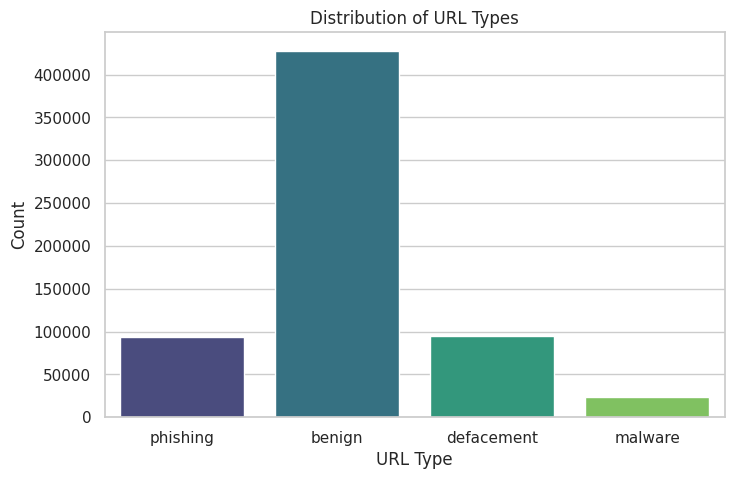

In [19]:
# Setting up plotting style

sns.set(style="whitegrid")

# Plotting the distribution of URL types
plt.figure(figsize=(8,5))
sns.countplot(x='type', data=data, palette='viridis')
plt.title("Distribution of URL Types")
plt.xlabel("URL Type")
plt.ylabel("Count")
plt.show()

# Feature Extraction from URLs

In [21]:
# 1. URL Length
data['url_length'] = data['url'].apply(len)

# 2. Count of Special Characters (@, -, ., //)
data['count_at'] = data['url'].apply(lambda x: x.count('@'))
data['count_dash'] = data['url'].apply(lambda x: x.count('-'))
data['count_dot'] = data['url'].apply(lambda x: x.count('.'))
data['count_double_dash'] = data['url'].apply(lambda x: x.count('//'))


# 3. Number of Subdomains(Calculate the number of subdomains by counting the number of dots (.))

data['num_subdomains'] = data['url'].apply(lambda x: x.count('.'))


# 4. Presence of IP Address in URL
# (Check if the URL contains an IP address instead of a domain name, which is common in phishing URLs.)

data['has_ip'] = data['url'].apply(lambda x: 1 if re.search(r'\b\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}\b', x) else 0)


# Presence of HTTPS
data['https'] = data['url'].apply(lambda x: 1 if 'https' in x else 0)


# displaying few rouws to verify features
data.head()

,url,type,type_encoded,url_length,count_at,count_dash,count_dot,count_double_dash,num_subdomains,has_ip,https
0,br-icloud.com.br,phishing,3,16,0,1,2,0,2,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,2,0,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,2,0,2,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,0,1,3,1,3,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,2,1,2,0,0


# Exploratory Data Analysis (EDA)

Step 1 - Visualize Feature Distributions

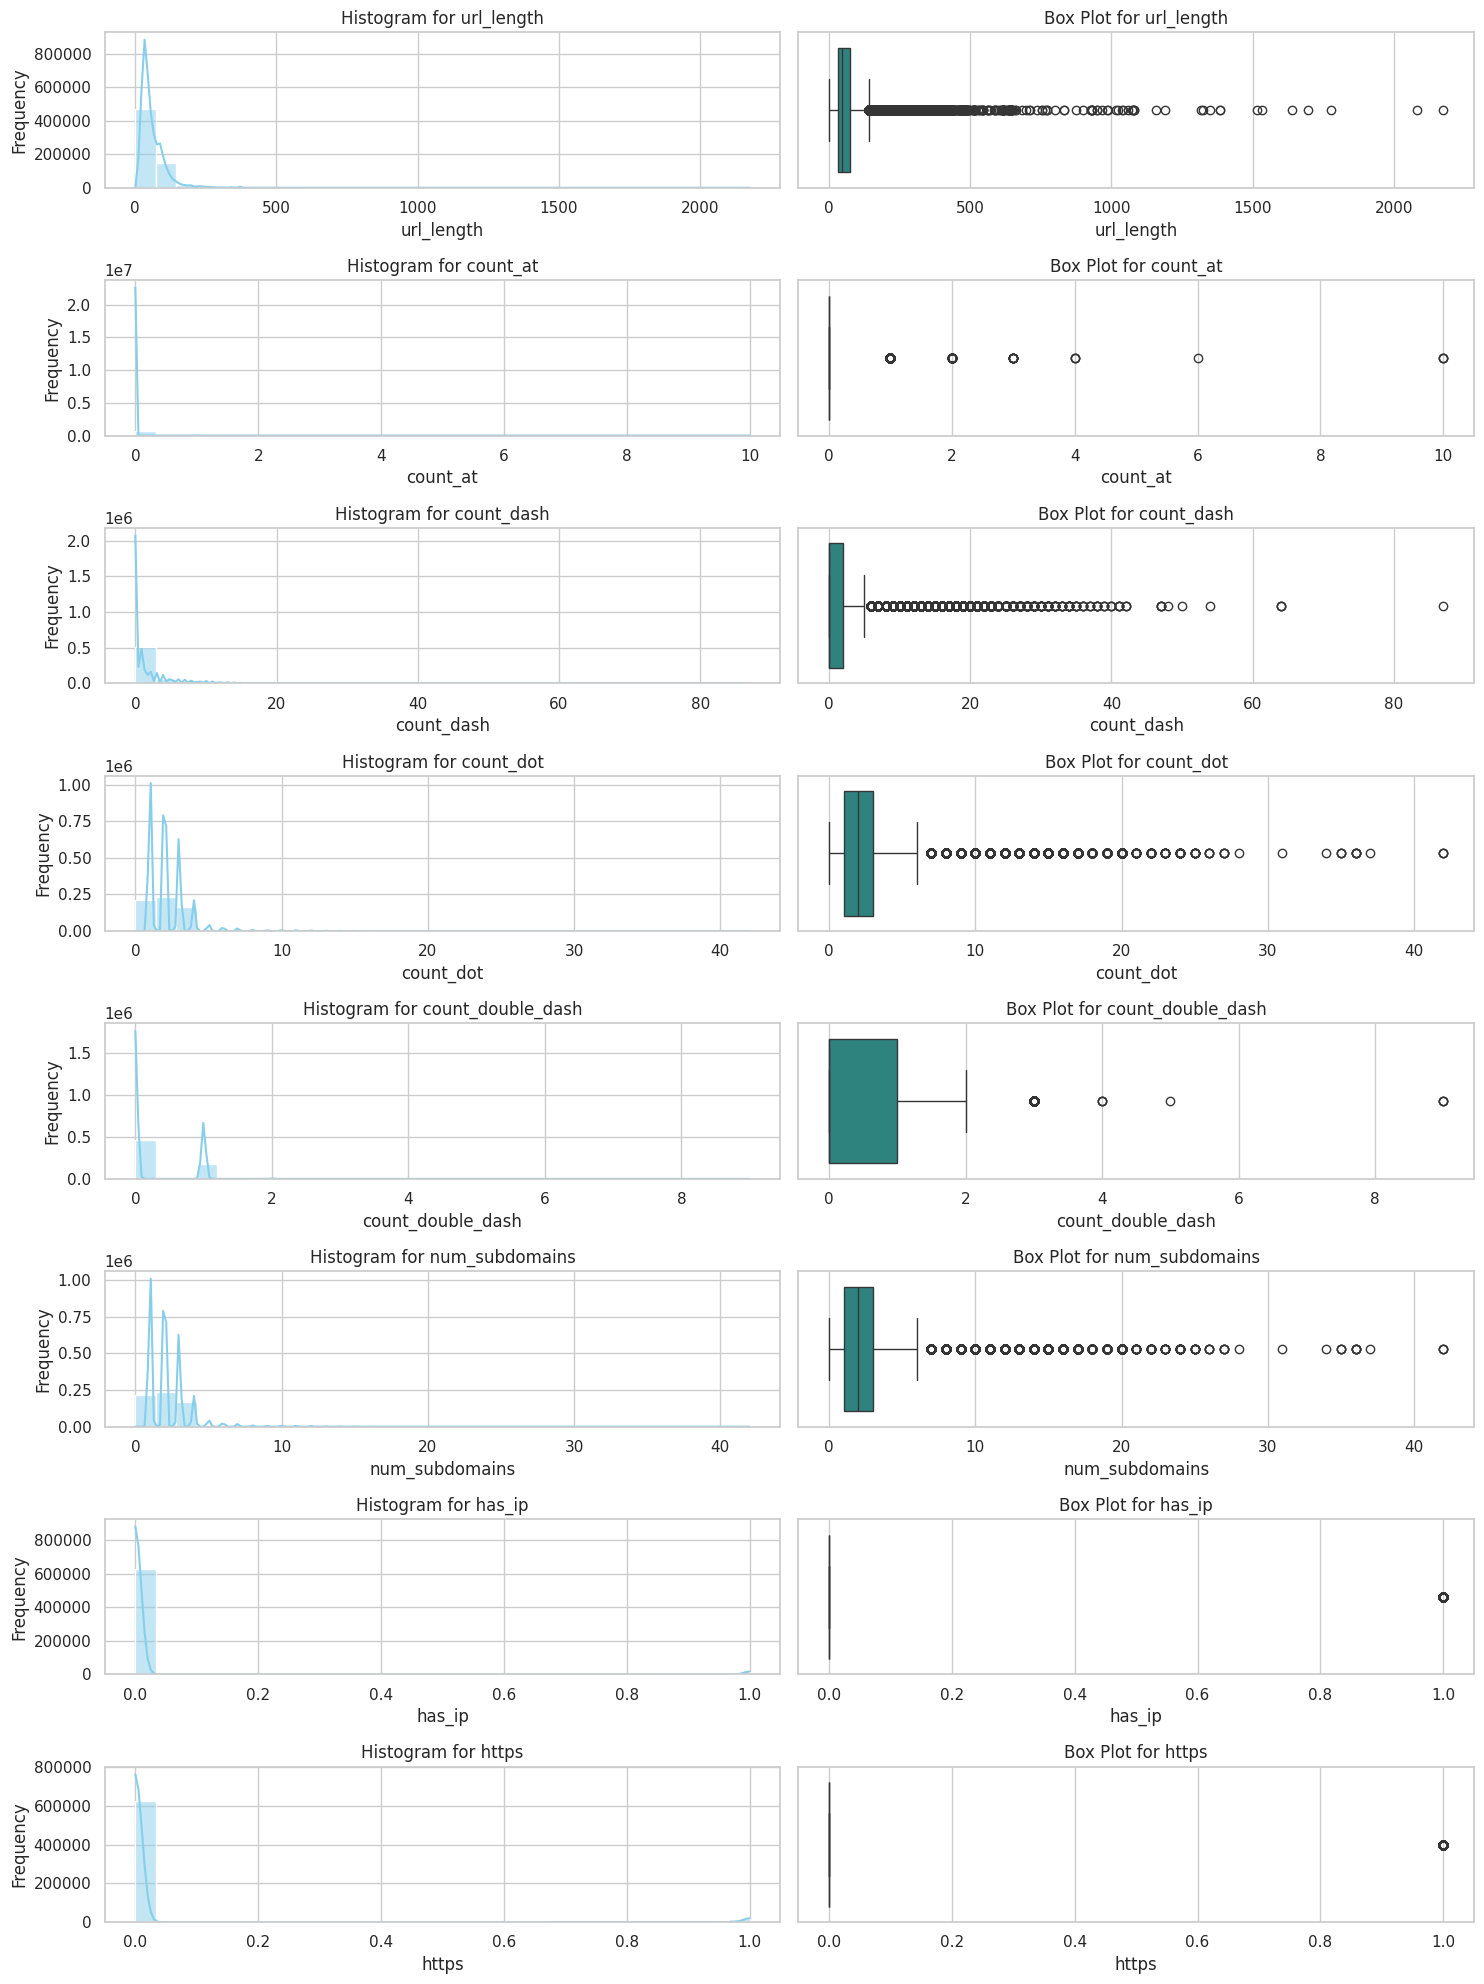

Number of outliers in url_length: 26512
Number of outliers in count_at: 1339
Number of outliers in count_dash: 59879
Number of outliers in count_dot: 10726
Number of outliers in count_double_dash: 210
Number of outliers in num_subdomains: 10726
Number of outliers in has_ip: 12358
Number of outliers in https: 16380


In [22]:
# Assuming you have your cleaned and pre-processed DataFrame as 'data_cleaned'
features = ['url_length','count_at', 'count_dash', 'count_dot', 'count_double_dash', 'num_subdomains', 'has_ip', 'https']

# Visualizing feature distributions with histograms and box plots
plt.figure(figsize=(15, 20))  # Adjust figure size to accommodate all plots

for i, feature in enumerate(features):
    # Plotting histogram
    plt.subplot(len(features), 2, 2 * i + 1)  # Creating subplot for histogram
    sns.histplot(data_cleaned[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Plotting box plot
    plt.subplot(len(features), 2, 2 * i + 2)  # Creating subplot for box plot
    sns.boxplot(data=data_cleaned, x=feature, palette='viridis')
    plt.title(f'Box Plot for {feature}')
    plt.xlabel(feature)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Function to calculate and count outliers using the IQR method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Counting the number of outliers for each feature
for feature in features:
    outliers = detect_outliers(data_cleaned, feature)
    print(f"Number of outliers in {feature}: {len(outliers)}")



# Removing Outliers

In [23]:
# Define a function to remove outliers based on the IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        # Calculate Q1 and Q3 for the column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        # Calculate the IQR
        IQR = Q3 - Q1
        # Define the lower and upper bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Remove rows that have outliers in this column
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# List of columns to remove outliers from
outlier_columns = ['url_length','count_at', 'count_dash', 'count_dot', 'count_double_dash', 'num_subdomains', 'has_ip', 'https']

# Apply the function to the data
data_cleaned = remove_outliers_iqr(data, outlier_columns)

# Display the shape of the dataset before and after removing outliers
print("Original dataset shape:", data.shape)
print("Dataset shape after outlier removal:", data_cleaned.shape)


Original dataset shape: (641113, 11)
Dataset shape after outlier removal: (356583, 11)


# Step 2 - Correlation Analysis

In [24]:
data.head()

,url,type,type_encoded,url_length,count_at,count_dash,count_dot,count_double_dash,num_subdomains,has_ip,https
0,br-icloud.com.br,phishing,3,16,0,1,2,0,2,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,35,0,0,2,0,2,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,31,0,0,2,0,2,0,0
3,http://www.garage-pirenne.be/index.php?option=...,defacement,1,88,0,1,3,1,3,0,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,235,0,1,2,1,2,0,0


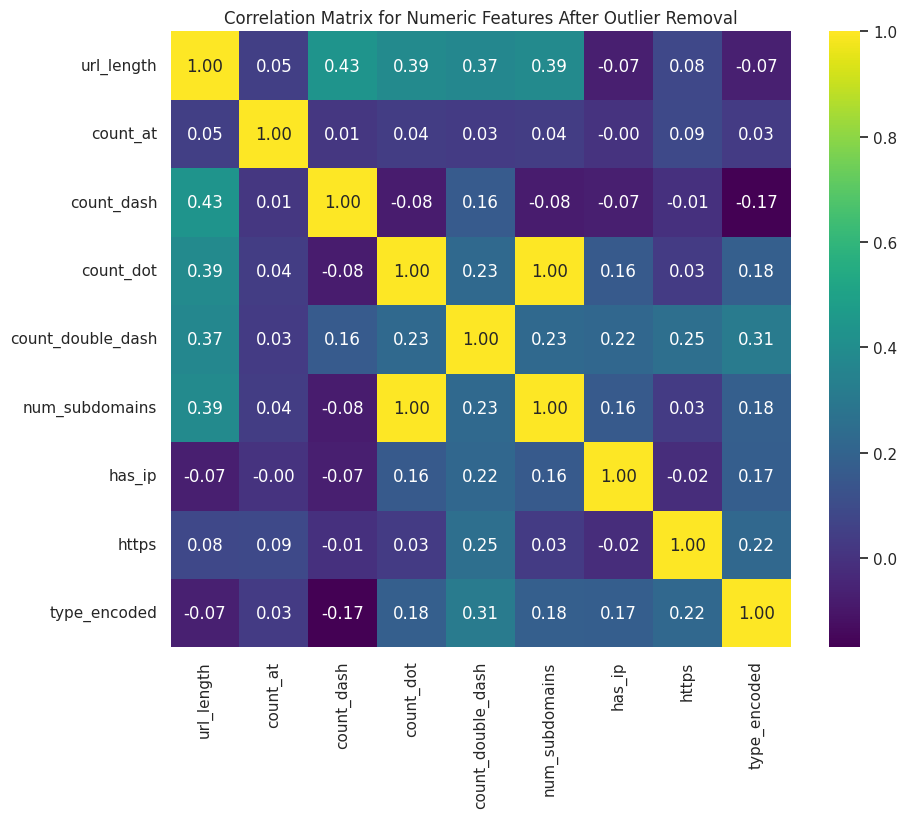

In [25]:
# Selecting only numeric features for correlation analysis
numeric_features = ['url_length', 'count_at', 'count_dash', 'count_dot', 'count_double_dash', 'num_subdomains', 'has_ip', 'https', 'type_encoded']

# Calculate the correlation matrix
correlation_matrix = data[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="viridis", fmt=".2f")
plt.title("Correlation Matrix for Numeric Features After Outlier Removal")
plt.show()

# Evaluate Feature Importance with a Model

In [26]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Split data into features and target
X = data[numeric_features].drop(columns=['type_encoded'])
y = data['type_encoded']

# Train a Random Forest model
rf_model = RandomForestClassifier(random_state=0)
rf_model.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

             Feature  Importance
4  count_double_dash    0.403701
0         url_length    0.214894
3          count_dot    0.104576
5     num_subdomains    0.104258
6             has_ip    0.061634
2         count_dash    0.057485
7              https    0.050697
1           count_at    0.002755


Finalize Feature Selection

In [27]:
# Finalizing feature selection based on previous analysis
selected_features = ['url_length', 'num_subdomains', 'count_dash', 'count_dot',
                     'count_double_dash', 'has_ip', 'https']
X = data[selected_features]
y = data['type_encoded']

# Split the Data into Training and Testing Sets

In [28]:
from sklearn.model_selection import train_test_split

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Training different Models

# Train a Random Forest Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.856141253909205
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     85575
           1       0.83      0.94      0.88     19023
           2       0.95      0.79      0.86      4699
           3       0.66      0.32      0.43     18926

    accuracy                           0.86    128223
   macro avg       0.83      0.75      0.77    128223
weighted avg       0.84      0.86      0.84    128223



# Train a Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logistic))


Logistic Regression Accuracy: 0.8056120976735843
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.89     85575
           1       0.71      0.93      0.81     19023
           2       0.80      0.65      0.72      4699
           3       0.37      0.04      0.07     18926

    accuracy                           0.81    128223
   macro avg       0.68      0.64      0.62    128223
weighted avg       0.75      0.81      0.75    128223



# Train a Decision Tree Model

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Initialize and train the Decision Tree model
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Make predictions
y_pred_tree = decision_tree.predict(X_test)

# Evaluate the model
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))



Decision Tree Accuracy: 0.85591508543709
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92     85575
           1       0.83      0.94      0.88     19023
           2       0.94      0.79      0.86      4699
           3       0.67      0.32      0.43     18926

    accuracy                           0.86    128223
   macro avg       0.83      0.75      0.77    128223
weighted avg       0.84      0.86      0.84    128223



# Train a Linear Model (Using LinearSVC - Linear Support Vector Classifier)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Initialize and train the LinearSVC model
linear_svc = LinearSVC(random_state=42, max_iter=10000)
linear_svc.fit(X_train, y_train)

# Make predictions
y_pred_linear_svc = linear_svc.predict(X_test)

# Evaluate the model
print("Linear SVC Accuracy:", accuracy_score(y_test, y_pred_linear_svc))
print("Linear SVC Classification Report:\n", classification_report(y_test, y_pred_linear_svc))


Linear SVC Accuracy: 0.8057524781045522
Linear SVC Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.96      0.90     85575
           1       0.71      0.93      0.81     19023
           2       0.84      0.52      0.64      4699
           3       0.40      0.05      0.09     18926

    accuracy                           0.81    128223
   macro avg       0.70      0.62      0.61    128223
weighted avg       0.75      0.81      0.75    128223



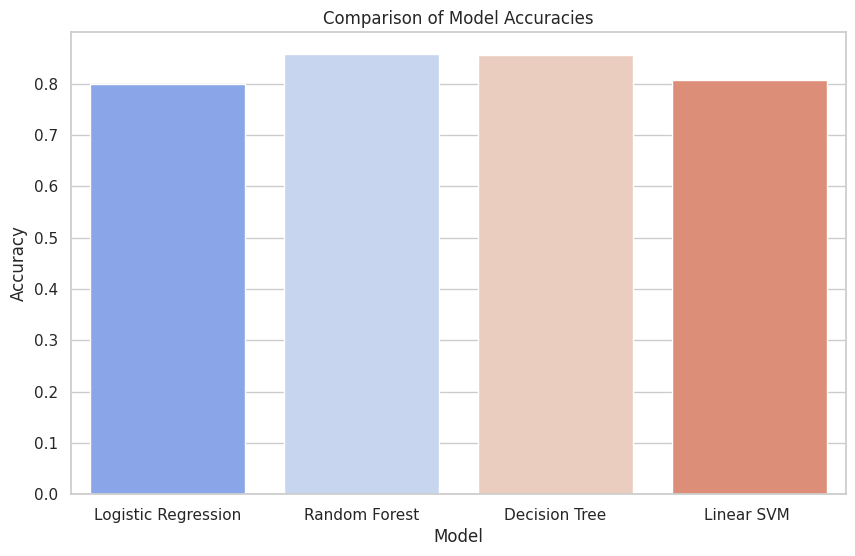

In [33]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have your data loaded into a pandas DataFrame `data`
# Columns used for feature extraction
X = data[['url_length', 'count_at', 'count_dash', 'count_dot', 'count_double_dash', 'num_subdomains', 'has_ip', 'https']]
y = data['type_encoded']  # Target variable (encoded types)

# Split the dataset into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Linear SVM " : LinearSVC(),
}

# Store accuracy results
accuracy_results = {}

# Train, test and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_results[model_name] = accuracy

# Create a bar plot for comparison of accuracy scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_results.keys()), y=list(accuracy_results.values()), palette='coolwarm')
plt.title("Comparison of Model Accuracies")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()
